In [25]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [26]:
# Load the .npy file
cube_data = np.load("apple_datacube.npy")

# Ensure the data is 3D
if cube_data.ndim != 3:
    raise ValueError("The loaded .npy file must contain a 3D array.")

In [27]:
## Helper methods

def extract_roi(data, x_start, x_end, y_start, y_end):
    """
    Extract a region of interest (ROI) from the 3D data cube.
    """
    if x_start < 0 or x_end > data.shape[0] or y_start < 0 or y_end > data.shape[2]:
        raise ValueError("ROI coordinates are out of bounds.")
    return data[x_start:x_end, :, y_start:y_end]




def create_rgb_composite(data, bands=(30, 20, 10)):  # NIR, Red, Green
    """
    Create RGB composite from selected bands
    """
    rgb = np.stack([data[:, band, :] for band in bands], axis=-1)  # Correct indexing
    
    # Normalize each channel separately
    rgb_norm = rgb - rgb.min(axis=(0, 1), keepdims=True)
    rgb_norm = rgb_norm / rgb_norm.max(axis=(0, 1), keepdims=True)
    
    # Apply gamma correction
    gamma = 1.5
    rgb_final = np.power(rgb_norm, 1 / gamma)
    
    return rgb_final

def analyze_band_statistics(data):
    """
    Compute basic statistics for each band
    """
    stats = {
        'mean': np.mean(data, axis=(0, 2)),
        'std': np.std(data, axis=(0, 2)),
        'min': np.min(data, axis=(0, 2)),
        'max': np.max(data, axis=(0, 2))
    }
    return stats


In [28]:
# Get the number of bands
num_bands = cube_data.shape[1]  # Bands are along the second axis
print(f"The dataset contains {num_bands} bands (0 to {num_bands - 1}).")

# Select a specific band (e.g., along the Z-axis)
band_index = 180  # Change this to the desired band index
if band_index < 0 or band_index >= num_bands:
    raise IndexError(f"Band index {band_index} is out of bounds for the Z-axis with size {num_bands}.")

# Extract the selected band
band_data = cube_data[:, band_index, :]  # Slice along the second axis

# Normalize the band data for visualization
normalized_band = (band_data - band_data.min()) / (band_data.max() - band_data.min())


The dataset contains 224 bands (0 to 223).


In [29]:
print("Band statistics:")
stats = analyze_band_statistics(cube_data)
for band_index, stat in enumerate(stats['mean']):
    print(f"Band {band_index}: Mean = {stat:.4f}, Std = {stats['std'][band_index]:.4f}, Min = {stats['min'][band_index]}, Max = {stats['max'][band_index]}")
    

Band statistics:
Band 0: Mean = 325.5509, Std = 2005.9629, Min = 147, Max = 52987
Band 1: Mean = 235.5781, Std = 7.3657, Min = 147, Max = 257
Band 2: Mean = 237.9152, Std = 8.2255, Min = 155, Max = 263
Band 3: Mean = 239.6636, Std = 9.6442, Min = 153, Max = 278
Band 4: Mean = 241.2763, Std = 11.2776, Min = 154, Max = 294
Band 5: Mean = 243.2374, Std = 13.0248, Min = 157, Max = 280
Band 6: Mean = 245.9585, Std = 15.7446, Min = 153, Max = 282
Band 7: Mean = 248.8527, Std = 18.6856, Min = 157, Max = 296
Band 8: Mean = 252.2998, Std = 21.3112, Min = 158, Max = 299
Band 9: Mean = 255.3675, Std = 23.8919, Min = 151, Max = 308
Band 10: Mean = 256.4745, Std = 25.5314, Min = 155, Max = 323
Band 11: Mean = 258.8298, Std = 27.5026, Min = 155, Max = 319
Band 12: Mean = 262.1813, Std = 30.4046, Min = 154, Max = 324
Band 13: Mean = 266.3013, Std = 33.0722, Min = 156, Max = 348
Band 14: Mean = 277.5788, Std = 43.4607, Min = 156, Max = 365
Band 15: Mean = 283.7551, Std = 48.6465, Min = 157, Max = 380


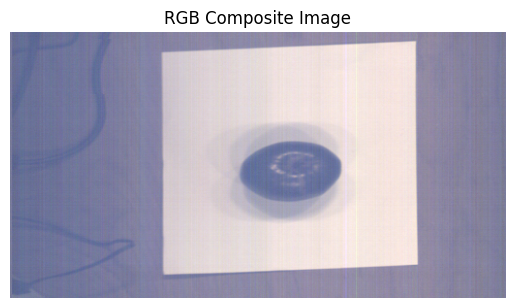

In [30]:
# Create an RGB composite image
rgb_image = create_rgb_composite(cube_data, bands=(30, 20, 10))  # NIR, Red, Green
plt.imshow(rgb_image)
plt.title("RGB Composite Image")
plt.axis("off")
plt.show()


In [31]:
x_start, x_end = 140, 140 + 20  # Define X-axis range for a 20-pixel square ROI
y_start, y_end = 160, 160 + 20  # Define Y-axis range for a 20-pixel square ROI
roi_data = extract_roi(cube_data, x_start, x_end, y_start, y_end)
print(f"Extracted ROI shape: {roi_data.shape}")

Extracted ROI shape: (20, 224, 20)


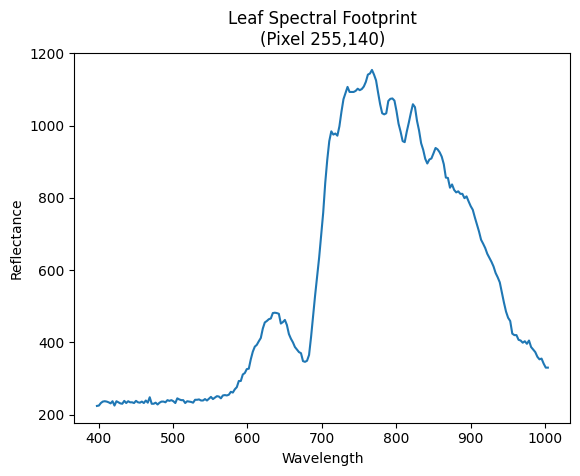

In [32]:
# Extract a single pixel's spectral data
pixel_y = 140
pixel_x = 255

pixel_data = cube_data[
    pixel_y:pixel_y+1,
    :,
    pixel_x:pixel_x+1
]

pixel_data_squeezed = np.squeeze(pixel_data)

# Generate a range of bands for plotting
bands = np.genfromtxt('bands.csv', delimiter=',')


plt.plot(bands, pixel_data_squeezed)
plt.title('Leaf Spectral Footprint\n(Pixel {},{})'.format(
    pixel_x, pixel_y))
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.show()

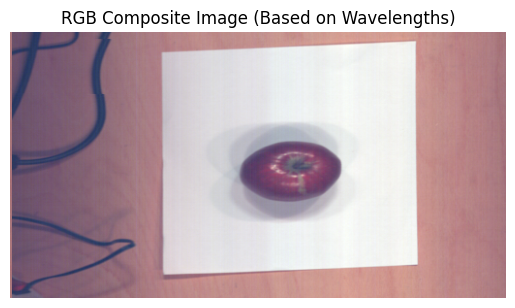

In [33]:
# Define the wavelength ranges for Red, Green, and Blue
red_range = (620, 750)   # Approximate range for red in nm
green_range = (495, 570) # Approximate range for green in nm
blue_range = (450, 495)  # Approximate range for blue in nm

# Find the indices of the bands that correspond to these wavelength ranges
red_band = np.argmin(np.abs(np.array(bands) - np.mean(red_range)))
green_band = np.argmin(np.abs(np.array(bands) - np.mean(green_range)))
blue_band = np.argmin(np.abs(np.array(bands) - np.mean(blue_range)))

# Create an RGB composite image using the identified bands
rgb_image = create_rgb_composite(cube_data, bands=(red_band, green_band, blue_band))

# Display the RGB image
plt.imshow(rgb_image)
plt.title("RGB Composite Image (Based on Wavelengths)")
plt.axis("off")
plt.show()